In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

spam.csv



# 1. Import dataset into pandas

In [26]:
sms = pd.read_csv("../input/spam.csv", encoding = "ISO-8859-1", usecols=[0,1], skiprows=1,
                  names=["label", "message"])
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [28]:
sms.label = sms.label.map({"ham":0, "spam":1})

In [56]:
# more negative (ham) cases than positive (spam)
sms.label.value_counts()

0    4825
1     747
Name: label, dtype: int64

# 2. Split into train & test sets

In [57]:
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(sms.message, 
                                                                            sms.label, 
                                                                            test_size=0.2)

# 3. Create Document Train Matrix

In [61]:
from sklearn.feature_extraction.text import CountVectorizer

couvec = CountVectorizer()
couvec.fit(features_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [62]:
# number of features or tokens
trained_features = couvec.get_feature_names()
print("Number of features vectorized:", len(trained_features))
print("Examples of trained features:", trained_features[1:10])

Number of features vectorized: 7695
Examples of trained features: ['000', '008704050406', '0089', '0121', '01223585236', '01223585334', '0125698789', '02', '0207']


In [69]:
# tokenized train documents
dtm_train = couvec.fit_transform(features_train)
print("Shape of dtm_train:", dtm_train.shape)
print(dtm_train[0:2]) # first two rows of sparse matrix

Shape of dtm_train: (4457, 7695)
  (0, 3385)	1
  (0, 5563)	1
  (0, 7639)	1
  (0, 7426)	1
  (0, 4378)	1
  (0, 6740)	1
  (0, 4771)	1
  (1, 6856)	1
  (1, 7347)	1
  (1, 3268)	1
  (1, 829)	1
  (1, 4641)	1
  (1, 2904)	1
  (1, 4061)	1
  (1, 5328)	1
  (1, 2931)	1
  (1, 5631)	1
  (1, 6887)	1
  (1, 2431)	1
  (1, 3154)	2
  (1, 4867)	1
  (1, 6804)	1
  (1, 924)	1


In [70]:
# tokenized test documents
dtm_test = couvec.transform(features_test)
print("Shape of dtm_test:", dtm_test.shape)

Shape of dtm_test: (1115, 7695)


# 4. Building and evaluating a model

## Multinomial Naive Bayes
> The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts.

In [71]:
# import and instantiate Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [72]:
# train the model
nb.fit(dtm_train, labels_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [73]:
# make predictions
labels_pred = nb.predict(dtm_test)

In [74]:
# accuracy not an important metric when positive and negative classes are skewed
from sklearn import metrics
metrics.accuracy_score(labels_test, labels_pred)

0.99013452914798206

In [75]:
# create confusion matrix to see precision and recall
metrics.confusion_matrix(labels_test, labels_pred)

array([[965,   0],
       [ 11, 139]])

In [78]:
# percentage of total spam detected i.e.recall
print("Recall:", metrics.recall_score(labels_test, labels_pred))
# percentage of positive (spam) predictions that are correct i.e. precision
print("Precision:", metrics.precision_score(labels_test, labels_pred))

Recall: 0.926666666667
Precision: 1.0


In [88]:
print("Order of classes in predict_proba:", nb.classes_)
print("Example class probabilities:", nb.predict_proba(dtm_test)[0])

Order of classes in predict_proba: [0 1]
Example class probabilities: [  9.99570023e-01   4.29977277e-04]


In [90]:
# since only ~15% of labels are positive (spam), a precision-recall curve is more useful than
# ROC curve
labels_prob = nb.predict_proba(dtm_test)[:, 1]
precisions, recalls, thresholds = metrics.precision_recall_curve(labels_test, 
                                                                 labels_prob)

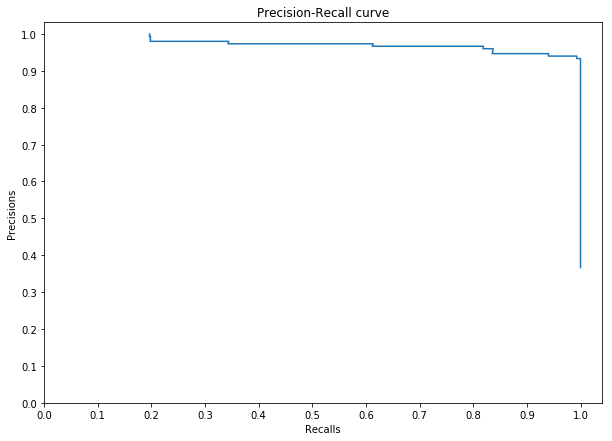

In [103]:
# plotting precision-recall curve
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(precisions[:-1], recalls[:-1])
plt.xlabel("Recalls")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Precisions")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Precision-Recall curve")
plt.show()